In [1]:

import cv2
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
from scipy.signal import find_peaks
from skimage.feature import canny
import os
from itertools import combinations


from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn import svm
import skimage as sk
import numpy as np
import argparse
import imutils
import pandas as panda
import random
from sklearn.model_selection import train_test_split
from skimage import transform
from skimage import morphology
from skimage import img_as_ubyte





In [2]:
path_to_dataset = r'digits_dataset'
target_img_size = (32, 32)
random_seed = 42  
random.seed(random_seed)
np.random.seed(random_seed)

In [65]:
def cleanImage(image, label = ""):
    # threshold = sk.filters.threshold_otsu(image)

    threshold = 0.8
    try:
        image = sk.transform.resize(image, target_img_size, mode='reflect', anti_aliasing=True)
    except:
        image = sk.transform.resize(image, target_img_size, mode='reflect', anti_aliasing=False)
    # print(np.histogram(image.flatten()))
    if np.max(image) <= 1 and threshold > 1:
        threshold = threshold / 255
    
    
    image[image > threshold] = 1
    image[image <= threshold] = 0

    # image = sk.morphology.skeletonize(image)

    # if (random.random() > 0.9 and label != "") :
    # sk.io.imshow(image)
    # sk.io.show()

    # if image.dtype != np.uint8:
    #     image = image.astype(np.uint8)

    # image = cv2.Canny(image, 0.5 * threshold, threshold)
        

    return image

In [66]:
def extract_hog_features(img):
    
    if img.dtype != np.uint8:
        img = np.uint8(img)

    win_size = (16, 16)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

In [50]:
def extract_features(image):
    image = cleanImage(image)
    return extract_hog_features(image)

In [59]:
def load_local_dataset(features,labels):
    img_filenames = os.listdir(path_to_dataset)

    for i, fn in enumerate(img_filenames):
        if fn.split('.')[-1] != 'jpg':
            continue

        label = fn.split('.')[0]
        labels.append(ord(label) - ord('a') + 1)

        path = os.path.join(path_to_dataset, fn)
        img = cv2.imread(path)
        features.append(extract_features(img))
        
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(img_filenames)))
        
    return features, labels        

In [67]:
def load_dataset():
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    features = []
    labels = []

    for i in range(len(train_images)):
        features.append(extract_features(train_images[i]))
        labels.append(train_labels[i])
    
    for i in range(len(test_images)):
        features.append(extract_features(test_images[i]))
        labels.append(test_labels[i])
    
    return features,labels   

In [68]:
classifier = KNeighborsClassifier(n_neighbors=5)

# from sklearn.svm import SVC
# classifier = SVC(kernel='linear')

In [69]:
def train_model(features, labels):
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=random_seed)

    print("############## Training ##############")
    classifier.fit(train_features, train_labels)
    
    # Test the model on images it hasn't seen before
    accuracy = classifier.score(test_features, test_labels)
    
    print('accuracy:', accuracy*100, '%')


In [70]:
features, labels = load_dataset()

In [71]:
train_model(features,labels)

############## Training ##############
accuracy: 96.89285714285715 %


In [62]:
def getNumberFromImage(img):
    img = binary_erosion(img,square(3))
    img = cleanImage(img)
    sk.io.imshow(img)
    result = classifier.predict([extract_features(img)])
    plt.title(result)
    sk.io.show()
    return result[0]


In [24]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [25]:
def gamma_correction(image, gamma):
    # Normalize pixel values to the range [0, 1]
    normalized_image = image / 255.0
    
    # Apply gamma correction
    corrected_image = np.power(normalized_image, gamma)
    
    # Denormalize the corrected image to the original range [0, 255]
    corrected_image = (corrected_image * 255).astype(np.uint8)
    
    return corrected_image

In [26]:
def is_high_brightness(image, threshold=205):

    # Calculate the average brightness
    average_brightness = np.mean(image)

    # Check if the average brightness is above the threshold
    return (average_brightness > threshold and average_brightness < 230 )

In [27]:
def adjust_brightness_iterative(image, window_size, iterations, step_size):
    # Convert the image to float32 for numerical calculations
    img_float = image.astype(np.float32)
    
    # Get image dimensions
    height, width = image.shape[:2]
    
    # Define the step size for moving the window
    step_h, step_w = step_size
    
    for _ in range(iterations):
        for h in range(0, height - window_size[0] + step_h + 1 , step_h):
            for w in range(0, width - window_size[1] + step_w + 1, step_w):
                # Extract the window
                window = img_float[h:h+window_size[0], w:w+window_size[1]]
    
                # Compute the average intensity of the window
                avg_intensity = np.mean(window)
               
                # Adjust the intensity of the entire window
                if (avg_intensity < 50):
                    img_float[h:min(h+window_size[0],height), w:min(w+window_size[1],width)] += 100
                elif (avg_intensity > 230):
                    img_float[h:min(h+window_size[0],height), w:min(w+window_size[1],width)] -= 50
                else:
                    img_float[h:min(h+window_size[0],height), w:min(w+window_size[1],width)] -= 50  
   

    # Clip the values to the valid range [0, 255]
    img_float = np.clip(img_float, 0, 255)
    
    # Convert the image back to uint8
    result_image = img_float.astype(np.uint8)
    
    return result_image

In [28]:
def is_very_high_brightness(image, threshold=230):

    # Calculate the average brightness
    average_brightness = np.mean(image)

    # Check if the average brightness is above the threshold
    return average_brightness > threshold

In [29]:
def is_low_brightness(image, threshold=50):

    # Calculate the average brightness
    average_brightness = np.mean(image)

    # Check if the average brightness is above the threshold
    return average_brightness < threshold

In [30]:
def calculate_quadrilateral_area(vertices):
    n = len(vertices)
    area = 0.5 * abs(np.dot(vertices[:, 0], np.roll(vertices[:, 1], 1)) - np.dot(vertices[:, 1], np.roll(vertices[:, 0], 1)))
    return area

def find_max_parallelogram(points):
    max_area = 0
    max_parallelogram = []

    # Generate all possible combinations of 4 points
    point_combinations = list(combinations(points, 4))

    for combination in point_combinations:
        p1, p2, p3, p4 = combination
        area = calculate_quadrilateral_area(np.squeeze(np.array([p1, p2, p3, p4]),axis=1))
        if area > max_area:
            max_area = area
            max_parallelogram = [p1, p2, p3, p4]

    return max_parallelogram

In [31]:
def getRectangleEdges(contour):
    epsilon = 0.04 * cv2.arcLength(contour, True)
    approx_contour = cv2.approxPolyDP(contour, epsilon, True)
    # selected_vertices = approx_contour[:4]
    hull = cv2.convexHull(approx_contour)
    selected_vertices = find_max_parallelogram(hull)
    box = np.int0(selected_vertices)
    
    # print(len(selected_vertices),len(box),hull)
    if len(box) < 4:
        return None
    # Sort the vertices based on their position in the convex hull
    ordered_box = sorted(box, key=lambda x: (x[0][0], x[0][1]))
    if ordered_box[0][0][1] > ordered_box[1][0][1]:
        ordered_box[0], ordered_box[1] = ordered_box[1], ordered_box[0]
    if ordered_box[2][0][1] > ordered_box[3][0][1]:
        ordered_box[2], ordered_box[3] = ordered_box[3], ordered_box[2]
    if ordered_box[0][0][0] > ordered_box[3][0][0]:
        ordered_box[0], ordered_box[3] = ordered_box[3], ordered_box[0]
    if ordered_box[1][0][0] > ordered_box[2][0][0]:
        ordered_box[0], ordered_box[3] = ordered_box[3], ordered_box[0]
    
    top_left,top_right, bottom_right, bottom_left = ordered_box
    return [tuple(top_right[0]), tuple(bottom_left[0]), tuple(top_left[0]), tuple(bottom_right[0])]

In [32]:
def doWork(imgPath):
    # read image
    originalImage = cv2.imread(imgPath)
    img = cv2.cvtColor(originalImage,cv2.COLOR_BGR2GRAY)
    originalImage = cv2.cvtColor(originalImage,cv2.COLOR_BGR2RGB)
    if is_high_brightness(img):
        img = cv2.equalizeHist(img)
        print("high Brightness Detected")
    elif is_very_high_brightness(img): 
        adjust_brightness_iterative(img,window_size=(20, 20), iterations=1, step_size=(20, 20))
    else:
        np.mean(img)
        np.max(img)
        np.min(img)
        np.median(img)
        # print(np.mean(img)/(np.max(img)-np.min(img)))
        gamma = (1.9*np.mean(img)/(np.max(img)-np.min(img)) + 0.1*np.median(img)/(np.max(img)-np.min(img)))/2
        img = gamma_correction(img,gamma)

    # get histogram and find peaks
    hist, bins = np.histogram(img.flatten(), bins=256, range=[0, 256],density=True)
    peaks, _ = find_peaks(hist, distance=40,height=0.0005, prominence=0.0001)

    # Plot the histogram and highlight the peaks
    # plt.plot(hist)
    # plt.plot(peaks, hist[peaks], 'ro')  # Mark peaks with red dots
    # plt.title('Image Histogram with Peaks')
    # plt.xlabel('Pixel Intensity')
    # plt.ylabel('Frequency')
    # plt.show()

    # segmentation
    if(len(peaks)>1):
        binaryThreshold = (peaks[0]+peaks[1]) /2
    else:   
        binaryThreshold = 125
    binary_image = 255 - cv2.threshold(img, binaryThreshold, 255, cv2.THRESH_BINARY)[1]

    # gaussian filter then opening then 2 dilations
    sigma = 1.2
    # binary_image = cv2.GaussianBlur(binary_image,(5,5),sigma)
    kernel1 = np.array([[0,1,1,1,0],[0,1,1,1,0],[0,1,1,1,0],[0,1,1,1,0],[0,1,1,1,0]], np.uint8)
    kernel2 = np.ones((1, 1), np.uint8)
    # binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel1,iterations=1)
    # binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel2,iterations=5)
    binary_image = cv2.dilate(binary_image, kernel1,iterations=3)
    # binary_image = cv2.erode(binary_image, kernel2,iterations=4)

    # binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel2,iterations=2)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = cv2.cvtColor(img.copy(),cv2.COLOR_GRAY2BGR)
    # contour_image = img.copy()
    largest_contour = max(contours, key=cv2.contourArea)
    # cv2.drawContours(contour_image, largest_contour, -1, (0, 255, 0), 2)
    rectangle = cv2.approxPolyDP(largest_contour, 0.04 * cv2.arcLength(largest_contour, True), True)
    rectangle = getRectangleEdges(rectangle)
    
    if not rectangle:
        print("No rectangles Found")
        # show_images([binary_image,contour_image],['thresholded image','contour_image'])
        return None
    
    cv2.line(contour_image, rectangle[0], rectangle[0], (255, 0, 0), 2)
    cv2.line(contour_image, rectangle[0], rectangle[1], (255, 0, 0), 2)
    cv2.line(contour_image, rectangle[0], rectangle[2], (255, 0, 0), 2)
    cv2.line(contour_image, rectangle[0], rectangle[3], (255, 0, 0), 2)
    cv2.line(contour_image, rectangle[1], rectangle[0], (0, 255, 0), 2)
    cv2.line(contour_image, rectangle[1], rectangle[1], (0, 255, 0), 2)
    cv2.line(contour_image, rectangle[1], rectangle[2], (0, 255, 0), 2)
    cv2.line(contour_image, rectangle[1], rectangle[3], (0, 255, 0), 2)
    cv2.line(contour_image, rectangle[2], rectangle[0], (0, 0, 255), 2)
    cv2.line(contour_image, rectangle[2], rectangle[1], (0, 0, 255), 2)
    cv2.line(contour_image, rectangle[2], rectangle[2], (0, 0, 255), 2)
    cv2.line(contour_image, rectangle[2], rectangle[3], (0, 0, 255), 2)
    cv2.line(contour_image, rectangle[3], rectangle[0], (255, 255, 0), 2)
    cv2.line(contour_image, rectangle[3], rectangle[1], (255, 255, 0), 2)
    cv2.line(contour_image, rectangle[3], rectangle[2], (255, 255, 0), 2)
    cv2.line(contour_image, rectangle[3], rectangle[3], (255, 255, 0), 2)

    # Define the original four points (source points) - specify them in the order top-left, top-right, bottom-right, bottom-left
    original_points = np.array([rectangle[0], rectangle[1], rectangle[2], rectangle[3]], dtype=np.float32)
    original_points = np.array([rectangle[2], rectangle[3], rectangle[1], rectangle[0]], dtype=np.float32)

    # Define the new four points (destination points)
    new_points = np.array([[0, 0], [400, 0], [400, 400], [0, 400]], dtype=np.float32)

    # Calculate the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(original_points, new_points)

    # Apply the perspective transformation to the image
    result = cv2.warpPerspective(originalImage, matrix, (400, 400))

    show_images([binary_image,contour_image,result],['thresholded image','contour_image','cropped_image'])
    return result

In [21]:
# Divider

In [33]:
from skimage.segmentation import flood_fill

def flood_image (binary_image, corner_percentage = 0.1):

    image_flooded = np.copy(binary_image)
    image_width = image_flooded.shape[0]
    image_height = image_flooded.shape[1]
    # for i in range(1,int(image_width*corner_percentage)):
    #     for j in range(1,int(image_height*corner_percentage)):
    #         image_flooded = flood_fill(image_flooded, (i, j), 0)
    #         image_flooded = flood_fill(image_flooded, (i, image_height-j), 0)
    #         image_flooded = flood_fill(image_flooded, (image_width-i, j), 0)
    #         image_flooded = flood_fill(image_flooded, (image_width-i, image_height-j), 0)
    for i in range(1,int(image_width*corner_percentage)):
        image_flooded = flood_fill(image_flooded, (i,int(image_height*corner_percentage)),0)
        image_flooded = flood_fill(image_flooded, (image_width-i,int(image_height*corner_percentage)),0)
        image_flooded = flood_fill(image_flooded, (i,image_height - int(image_height*corner_percentage)),0)
        image_flooded = flood_fill(image_flooded, (image_width-i,image_height - int(image_height*corner_percentage)),0)
    for j in range(1,int(image_height*corner_percentage)):
        image_flooded = flood_fill(image_flooded, (int(image_width*corner_percentage),j),0)
        image_flooded = flood_fill(image_flooded, (int(image_width*corner_percentage),image_height-j),0)
        image_flooded = flood_fill(image_flooded, (image_width - int(image_width*corner_percentage),j),0)
        image_flooded = flood_fill(image_flooded, (image_width - int(image_width*corner_percentage),image_height-j),0)

    return image_flooded

def flood_cells (binary_cells,x=9,y=9):
    cell_width = binary_cells[0,0].shape[0]
    cell_height = binary_cells[0,0].shape[1]
    cells_flooded = np.copy(binary_cells)
    for i in range(9):
        for j in range(9):
            cells_flooded[i,j] = flood_image(binary_cells[i,j])

    return cells_flooded

In [34]:
def gridDivider (binary_image, x=9,y=9):
    # Get image height, width
    cell_width = int(binary_image.shape[0]/x)
    cell_height = int(binary_image.shape[1]/y)
    # record each cell
    cells = np.zeros((x, y, cell_width, cell_height))

    # Remove noise 
    for i in range(x):
        for j in range(y):
            cells[i,j] =  binary_image[cell_width*i:cell_width*(i+1),cell_height*j:cell_height*(j+1)]*255

    # cells_no_noise = reduce_cells_noise(cells_flooded)
    
    return cells



# def gridDivider (binary_image, x=9,y=9):
#     # Get image height, width
#     cell_width = int(binary_image.shape[0]/x)
#     cell_height = int(binary_image.shape[1]/y)
#     # record each cell
#     cells = np.zeros((x, y, cell_width+10, cell_height+10))

#     # Remove noise 
#     for i in range(x):
#         for j in range(y):
#             x1 = max(cell_width*i-5,0)
#             y1 = min(cell_width*(i+1)+5,binary_image.shape[0]-1)
#             x2 = max(cell_height*j-5,0)
#             y2 = min(cell_height*(j+1)+5,binary_image.shape[1]-1)
#             # if(i == 0 and j == 0):
#             #     y1 += 5
#             #     y2 += 5
#             # elif (i == 0 and j == 8):
#             #     x2 -= 5

#             cells[i,j] = transform.resize(binary_image[x1:y1,x2:y2]*255, (cell_width +10, cell_height+10), mode='constant', anti_aliasing=True)

#     # cells_no_noise = reduce_cells_noise(cells_flooded)
    
#     return cells

In [35]:
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin, square


def reduce_noise (binary_image, dialtion_size=4, erosion_size=4):
    cell_erosion_img = binary_erosion(binary_image, square(erosion_size))
    reduced_noise_img = binary_dilation(cell_erosion_img, square(dialtion_size))

    return reduced_noise_img

def reduce_cells_noise (binary_cells,x=9,y=9):
    cell_width = binary_cells[0,0].shape[0]
    cell_height = binary_cells[0,0].shape[1]
    cells_no_noise = np.zeros((x, y, cell_width, cell_height))
    for i in range(9):
        for j in range(9):
            cells_no_noise[i,j] = reduce_noise(binary_cells[i,j])
    
    return cells_no_noise

In [36]:
from skimage import  measure
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin, square


def center_object(binary_image):
    binary_image = binary_erosion(binary_image, square(2))
    try:

        # Find connected objects
        labeled_image = measure.label(binary_image)

        # Find largest one
        regions = measure.regionprops(labeled_image)
        largest_region = max(regions, key=lambda region: region.area)

        # Get centroid coordinates
        centroid = largest_region.centroid

        # Calc shift to center the object
        shift_x = int(binary_image.shape[1] / 2 - centroid[1])
        shift_y = int(binary_image.shape[0] / 2 - centroid[0])

        # Shift image to center the object
        centered_image = np.roll(binary_image, shift_x, axis=1)
        centered_image = np.roll(centered_image, shift_y, axis=0)
        

        return centered_image
    except:
        return binary_image

def centere_cells (binary_cells,x=9,y=9):
    cell_width = binary_cells[0,0].shape[0]
    cell_height = binary_cells[0,0].shape[1]
    cells_centered = np.zeros((x, y, cell_width, cell_height))
    for i in range(9):
        for j in range(9):
            cells_centered[i,j] = center_object(binary_cells[i,j])
    
    return cells_centered

In [37]:
def approach2(binary_image):
    
    # image_erosion = binary_erosion(binary_image, square(4))

    image_grid_removed = flood_image(binary_image,0.02)
    image_dilation = binary_dilation(image_grid_removed, square(4))
    # show_images([image_dilation],["image_grid_removed"])

    # divide image into 81 cells (9*9 cells)
    binary_cells = gridDivider(image_dilation)
    # show_images(binary_cells[1],["cells_flooded without_grid"]*9)

    # Remove borders AGAIN, background by flooding
    cells_flooded = flood_cells(binary_cells)
    # show_images(cells_flooded[1],["cells_flooded_Again without_grid"]*9)

    return cells_flooded
    

In [38]:
from skimage.filters import threshold_minimum
from skimage import filters

def getBinaryGrid(img):
    # # Get binary img
    imgCopy = np.copy(img)
    try:
        imgCopy = rgba2rgb(imgCopy)
    except:
        pass

    gray_image = rgb2gray(imgCopy)
    # show_images([gray_image],["gray_image"])

    filtered_image = filters.gaussian(gray_image, sigma=0.5)

    # get thresholded image 
    thresh_min = threshold_minimum(filtered_image*255)
    binary_image = gray_image*255 < thresh_min
    # show_images([binary_image],["binary_image"])

    return binary_image



# def getBinaryGrid(img):
#     # # Get binary img
#     # imgCopy = np.copy(img)
#     # try:
#     #     imgCopy = rgba2rgb(imgCopy)
#     # except:
#     #     pass

#     # gray_image = rgb2gray(imgCopy)
#     # show_images([gray_image],["gray_image"])

#     # filtered_image = filters.gaussian(gray_image, sigma=0.5)

#     # # get thresholded image 
#     # thresh_min = threshold_minimum(filtered_image*255)
#     # binary_image = gray_image*255 < (thresh_min+20)
#     # show_images([binary_image],["binary_image"])
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     hist, bins = np.histogram(img.flatten(), bins=256, range=[0, 256],density=True)
#     peaks, _ = find_peaks(hist, distance=40,height=0.0005, prominence=0.0001)

#     # Plot the histogram and highlight the peaks
#     # plt.plot(hist)
#     # plt.plot(peaks, hist[peaks], 'ro')  # Mark peaks with red dots
#     # plt.title('Image Histogram with Peaks')
#     # plt.xlabel('Pixel Intensity')
#     # plt.ylabel('Frequency')
#     # plt.show()

#     # segmentation
#     if(len(peaks)>1):
#         binaryThreshold = (peaks[0]+peaks[1]) /2
#     else:   
#         binaryThreshold = 125
#     binary_image = 255 - cv2.threshold(img, binaryThreshold, 255, cv2.THRESH_BINARY)[1]

#     return binary_image

In [40]:
def doWork2(img):

    binary_image = getBinaryGrid(img) # convert image to binary

    cells_flooded = approach2(binary_image) #

    cells_centered = centere_cells(cells_flooded)

    # for i in range(9): 
    #     show_images(cells_centered[i],["cells_centered without_grid"]*9)

    return cells_centered



In [ ]:
tempimg = doWork('./Untitled.png')
numbers = doWork2(tempimg)
printedNumbers = numbers[0]
blackBlock = numbers[1][1]
print(printedNumbers[0].shape)
show_images([blackBlock])

In [34]:
M = 9
def puzzle(a):
    for i in range(M):
        for j in range(M):
            print(a[i][j],end = " ")
        print()
def solve(grid, row, col, num):
    for x in range(9):
        if grid[row][x] == num:
            return False
             
    for x in range(9):
        if grid[x][col] == num:
            return False
 
 
    startRow = row - row % 3
    startCol = col - col % 3
    for i in range(3):
        for j in range(3):
            if grid[i + startRow][j + startCol] == num:
                return False
    return True
 
def Suduko(grid, row, col):
 
    if (row == M - 1 and col == M):
        return True
    if col == M:
        row += 1
        col = 0
    if grid[row][col] > 0:
        return Suduko(grid, row, col + 1)
    for num in range(1, M + 1, 1): 
     
        if solve(grid, row, col, num):
         
            grid[row][col] = num
            if Suduko(grid, row, col + 1):
                return True
        grid[row][col] = 0
    return False

input_sample_01.jpg


C:\Users\User\AppData\Local\Temp\ipykernel_23148\522265365.py:7: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(selected_vertices)


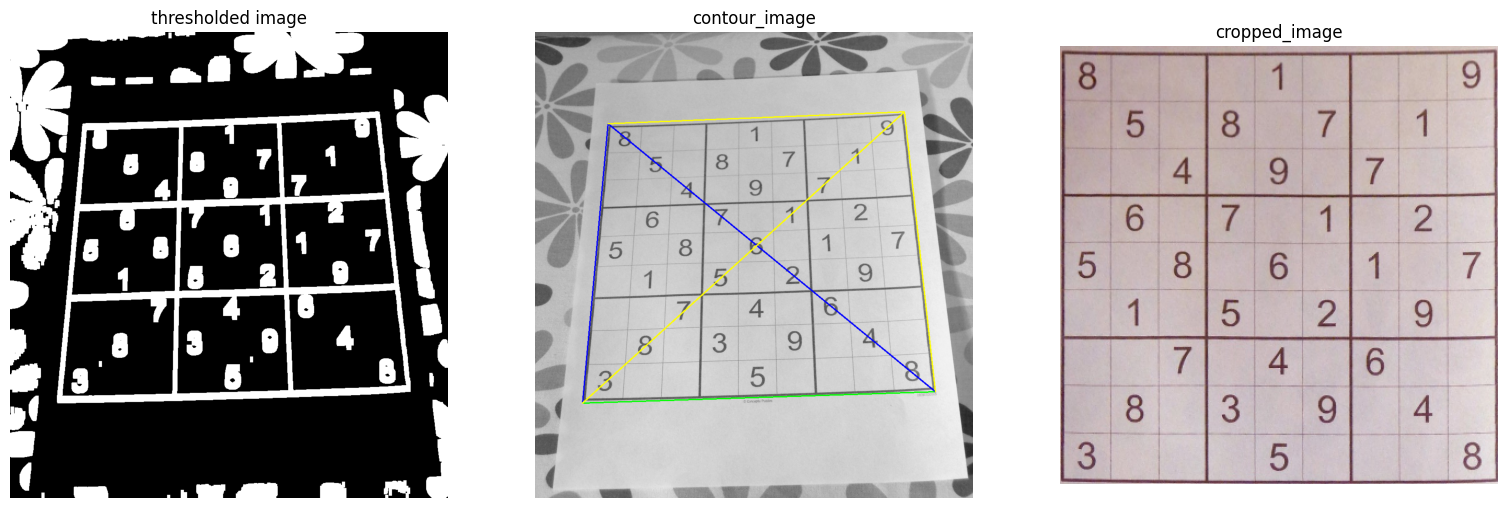

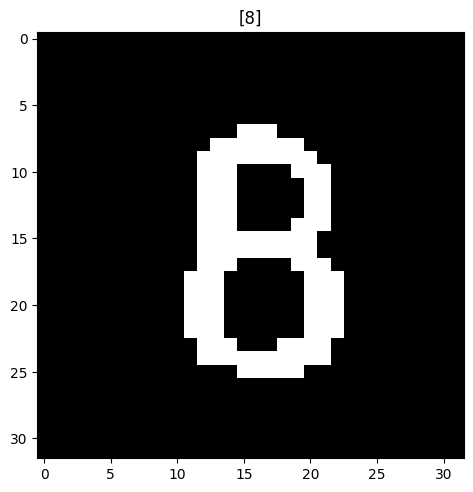

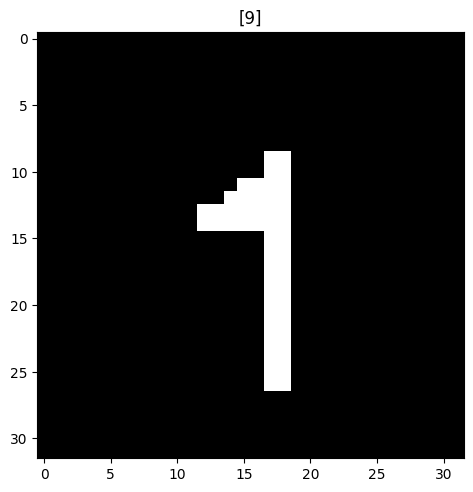

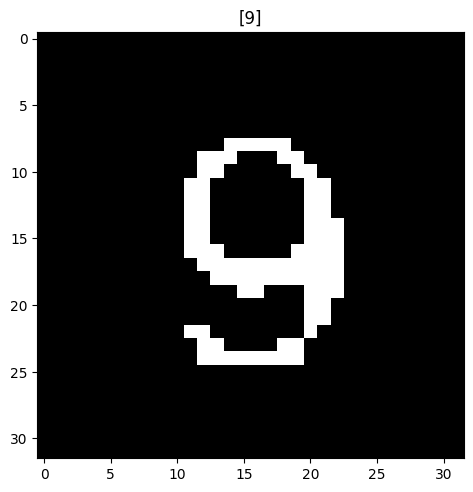

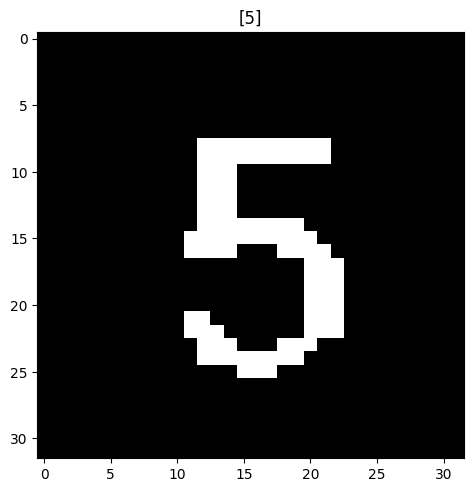

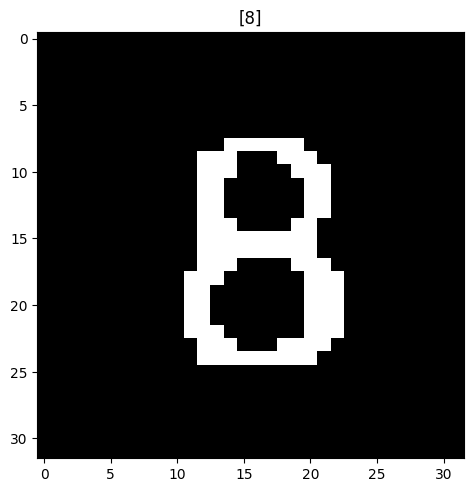

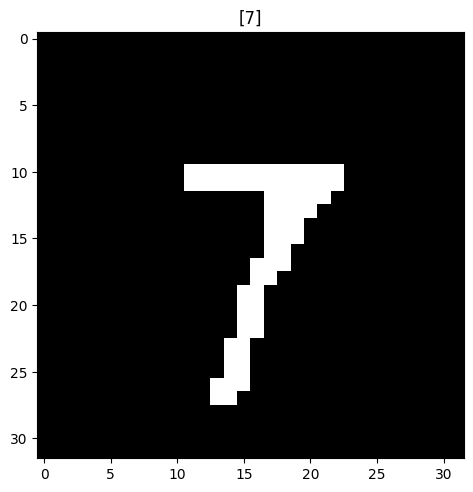

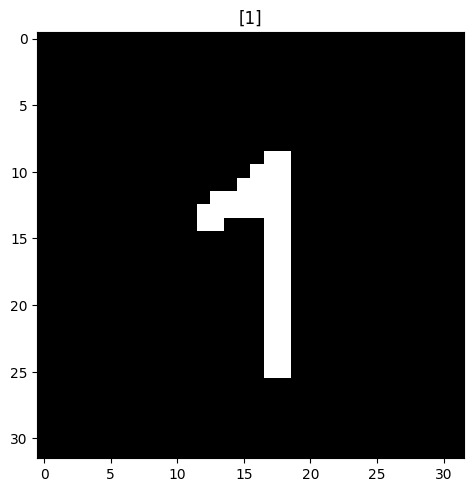

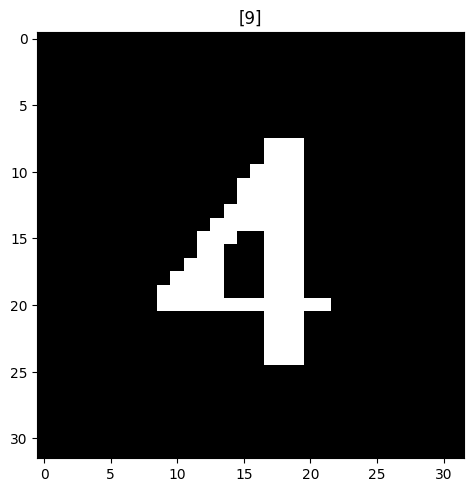

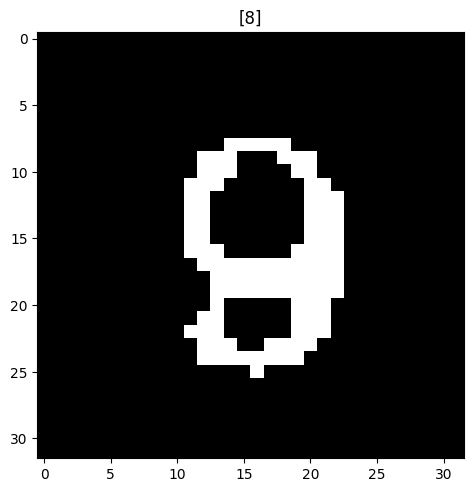

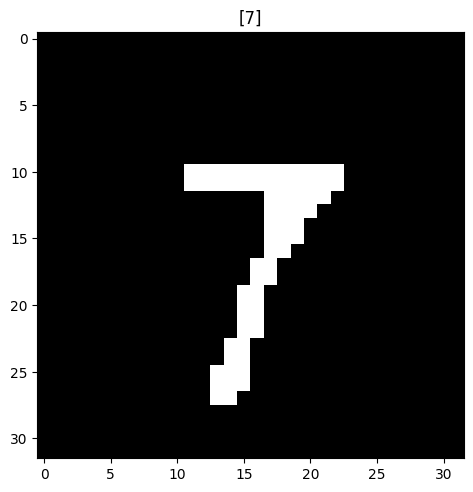

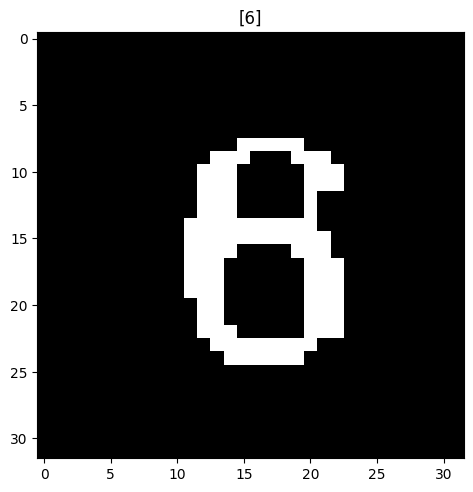

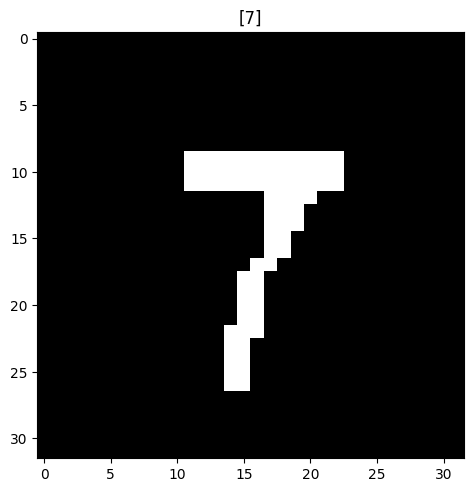

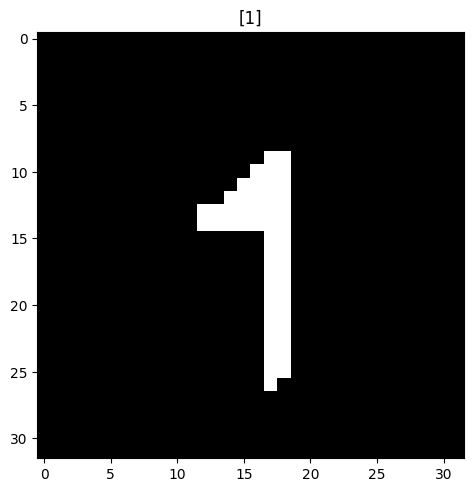

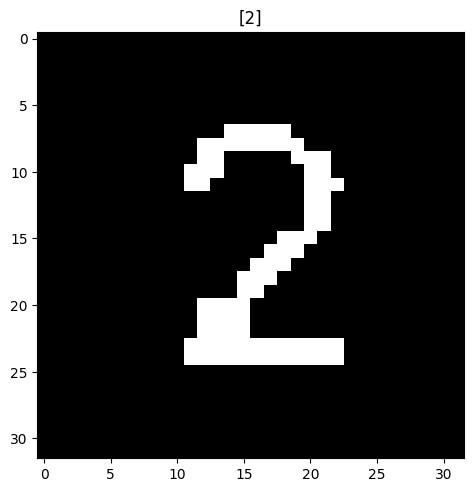

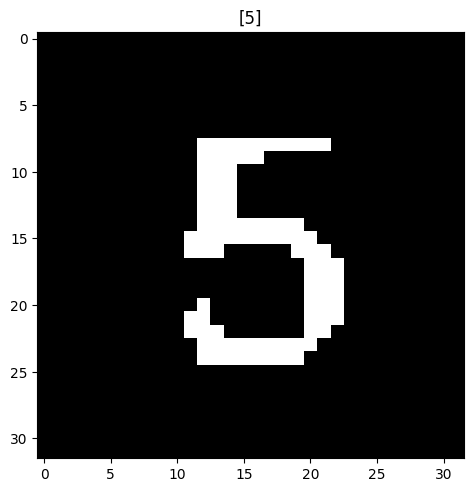

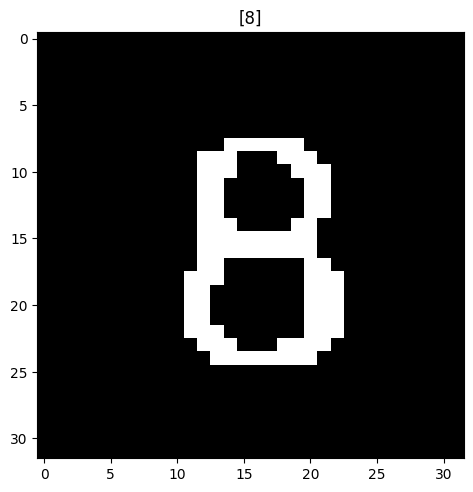

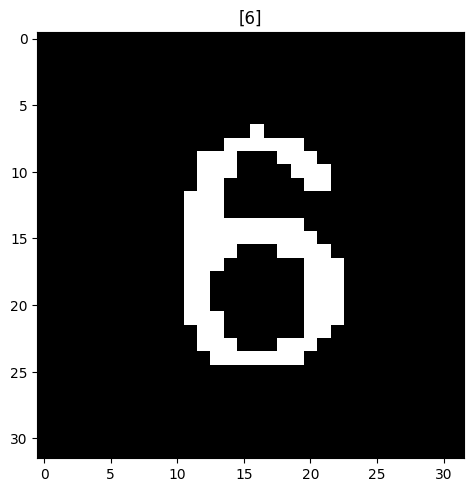

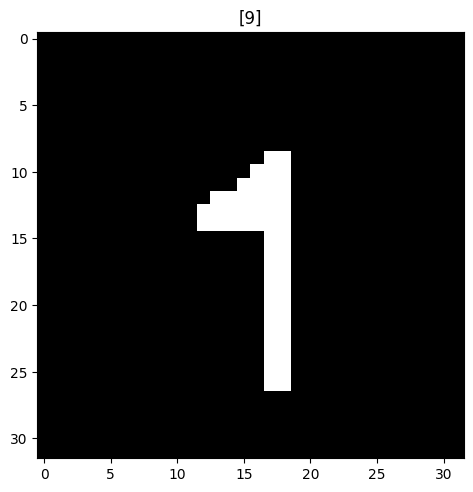

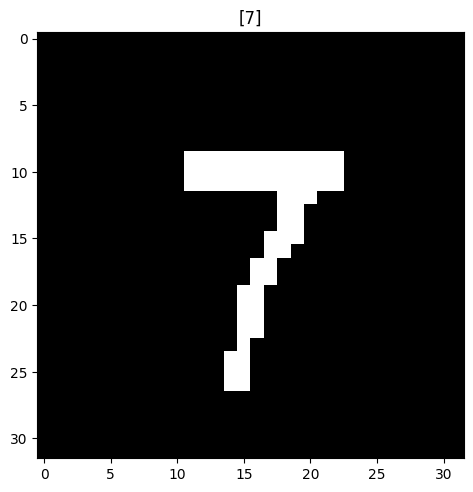

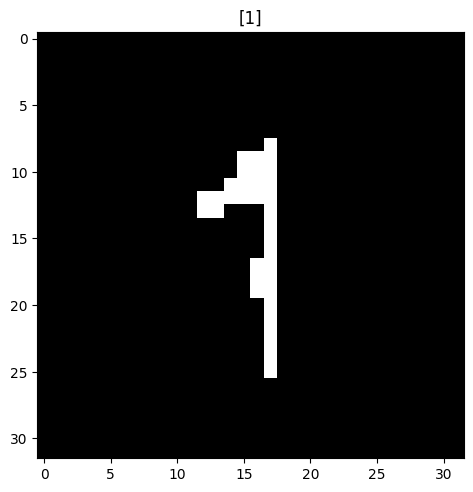

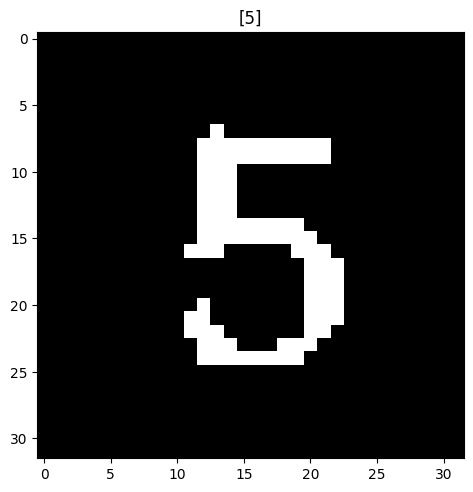

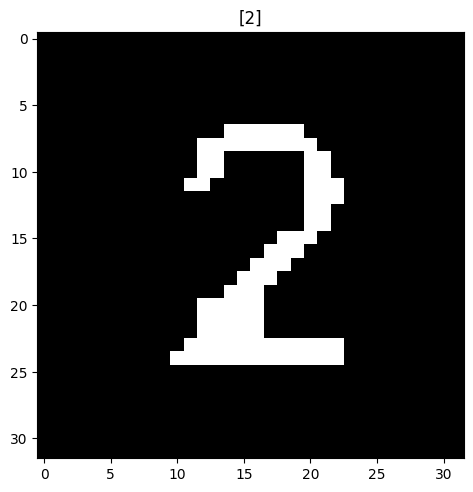

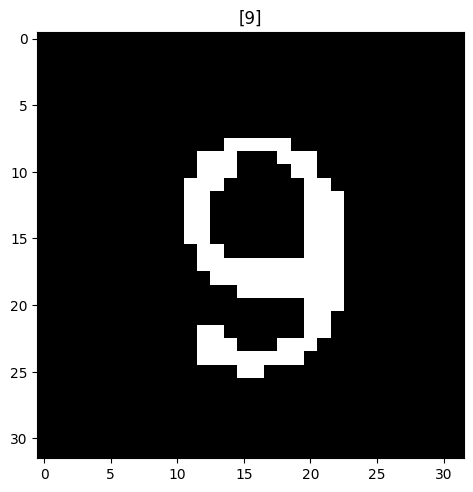

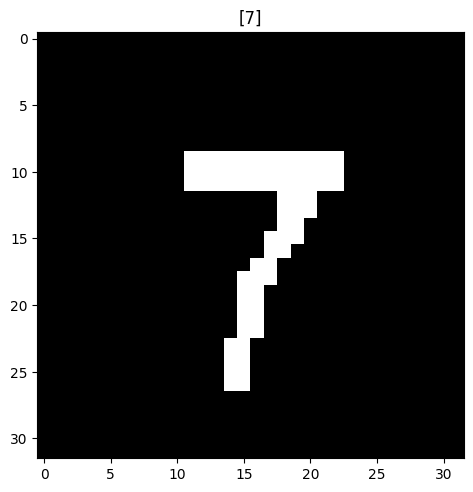

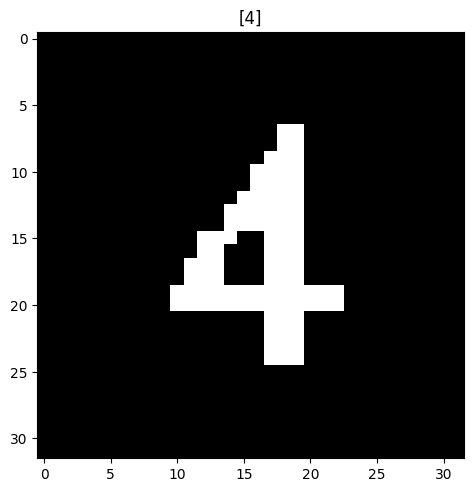

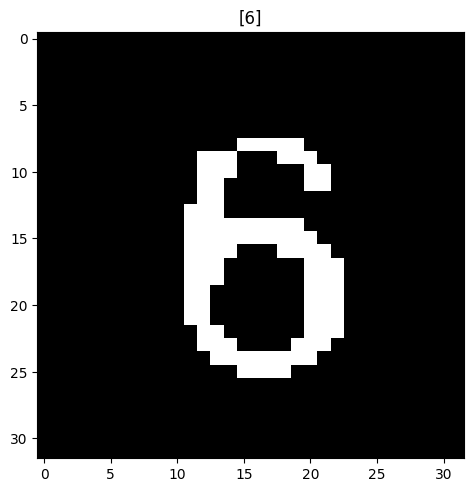

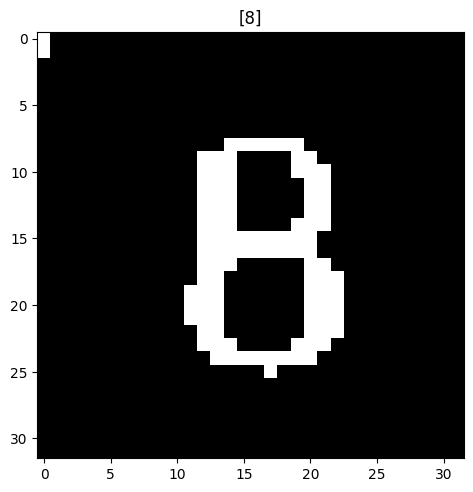

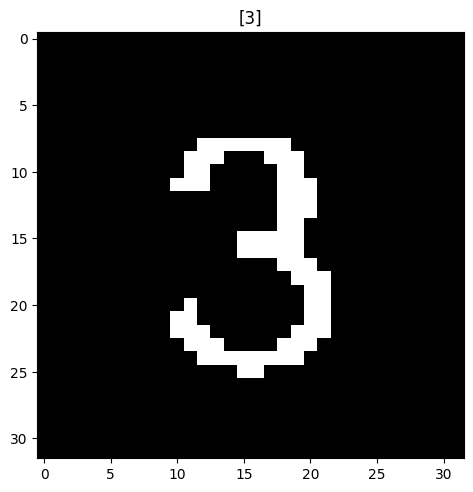

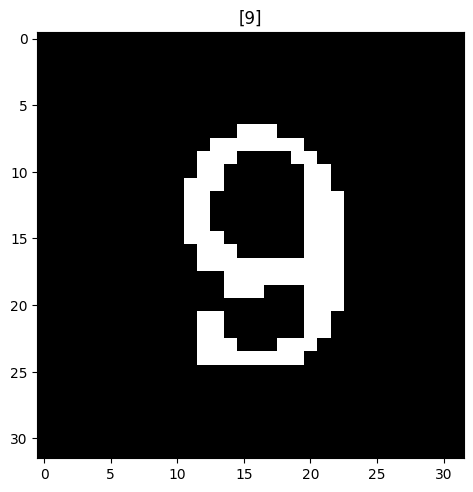

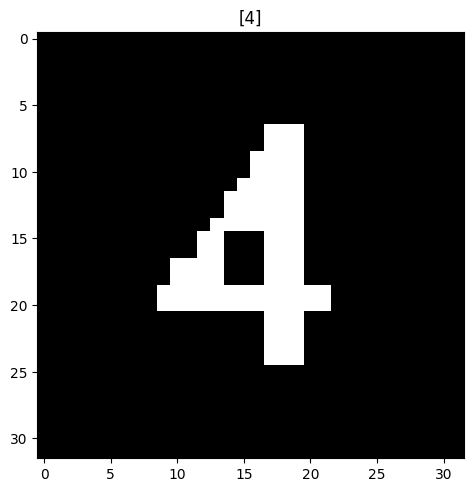

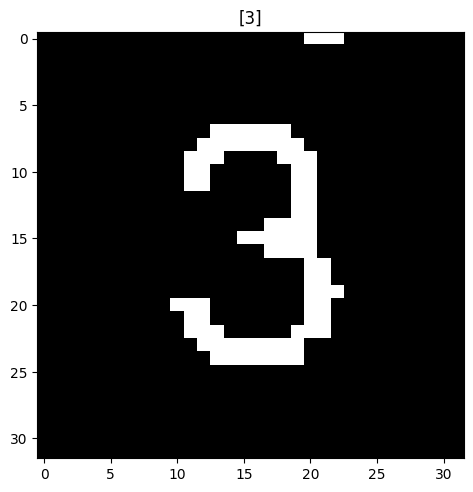

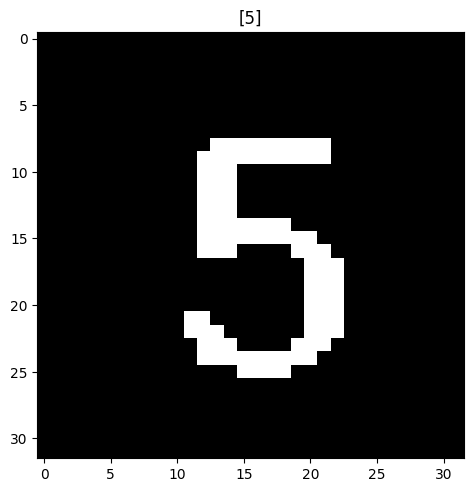

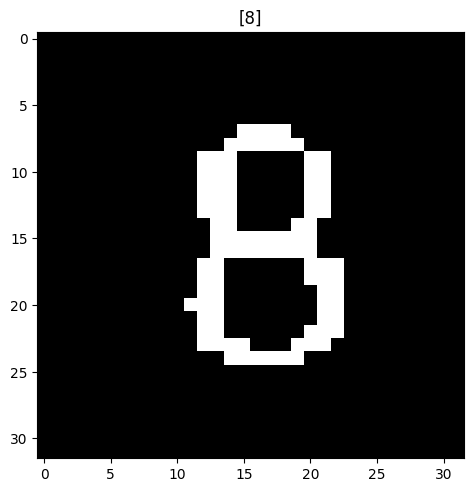

[[8. 0. 0. 0. 9. 0. 0. 0. 9.]
 [0. 5. 0. 8. 0. 7. 0. 1. 0.]
 [0. 0. 9. 0. 8. 0. 7. 0. 0.]
 [0. 6. 0. 7. 0. 1. 0. 2. 0.]
 [5. 0. 8. 0. 6. 0. 9. 0. 7.]
 [0. 1. 0. 5. 0. 2. 0. 9. 0.]
 [0. 0. 7. 0. 4. 0. 6. 0. 0.]
 [0. 8. 0. 3. 0. 9. 0. 4. 0.]
 [3. 0. 0. 0. 5. 0. 0. 0. 8.]]


NameError: name 'printedNumbers' is not defined

In [63]:
files = os.listdir('./')

    # Filter only JPG files
jpg_files = [file for file in files if file.lower().endswith(".jpg")]

    # Read each JPG file
for jpg_file in jpg_files:
    file_path = os.path.join('./', jpg_file)
    print(jpg_file)
    img = doWork(file_path)
    #taher part here
    imgs = doWork2(img)

    sudokuGrid = np.zeros((9,9))

    count = 0
    kernel = np.ones((4, 4), np.uint8)
    for i in range(9):
        for j in range(9):
            # detect the image if it contains number ot not
            tempImg = np.zeros(target_img_size)
            tempImg = cv2.resize(imgs[i][j],target_img_size).astype(np.uint8)
            pixelsCount = np.sum(tempImg == 1)
            tempImg = cv2.erode(tempImg, kernel, iterations=1)


            # Convert the skeletonized image to uint8 format for display
            # tempImg = morphology.skeletonize(tempImg)
            # tempImg = img_as_ubyte(tempImg)


            # tempImg = cv2.morphologyEx(tempImg, cv2.MORPH_CLOSE, kernel)


            # tempImg = np.where(tempImg == 1, 255, tempImg)

            if pixelsCount > 30:
                count+=1 # count to determine number of cells contain number
                sudokuGrid[i][j] = getNumberFromImage(imgs[i][j])

    # sudokuGrid[0][8] = 9
    # sudokuGrid[2][2] = 4
    # sudokuGrid[2][4] = 9
    # sudokuGrid[3][1] = 6
    # sudokuGrid[4][0] = 5
    # sudokuGrid[5][7] = 9
    # sudokuGrid[6][4] = 4
    # sudokuGrid[7] = [0,8,0,3,0,9,0,4,0]


    print(sudokuGrid)  
    input = np.zeros((400, 400))
    for i in range(9):
        for j in range(9):
            if(sudokuGrid[i][j] == 0):
                input[i*44:(i*44)+44,j*44:(j*44)+44] = blackBlock
            else:
                input[i*44:(i*44)+44,j*44:(j*44)+44] = printedNumbers[int(sudokuGrid[i][j])-1]

    if (Suduko(sudokuGrid, 0, 0)):
        puzzle(sudokuGrid)
        answer = np.zeros((400, 400))

        # Remove noise 
        for i in range(9):
            for j in range(9):
                answer[i*44:(i*44)+44,j*44:(j*44)+44] = printedNumbers[int(sudokuGrid[i][j])-1]

        show_images([input,answer],['input' , 'answer'])       
    else:
        print("Solution does not exist:(")          
